In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/phip-PanCoV-SARSCoV2.csv', index_col=0)

#
# Add column indicating if peptide enrichment passes p-value
# cutoff corresponding to the desired false positive rate.
#
fpr = 0.05
metric = 'edgeR_logpval'

pass_cutoff=[]
for i,row in df.iterrows():
    metric_val = row[metric]
    if metric_val > -np.log10(fpr):
        pass_cutoff.append(1)
    else:
        pass_cutoff.append(0)

df['pass_cutoff'] = pass_cutoff

#
# Collapse the 2 replicates and take the average enrichment if both replicates pass p-value cutoff,
# otherwise set the "average" enrichment as zero.
#
cutoff_enr_df = df.groupby(['sample_ID','mAb_target','participant_ID','Virus','Prot_Start','Prot']).apply(
    lambda x : np.prod(x['pass_cutoff'])*np.mean(x['enrichment'])
).reset_index(name='avg_cutoff_enr')
cutoff_enr_df

,sample_ID,mAb_target,participant_ID,Virus,Prot_Start,Prot,avg_cutoff_enr
0,20C.119,S2,20c,SARSCoV2,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYP,0.0
1,20C.119,S2,20c,SARSCoV2,21,RTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFF,0.0
2,20C.119,S2,20c,SARSCoV2,41,KVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRF,0.0
3,20C.119,S2,20c,SARSCoV2,61,NVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSN,0.0
4,20C.119,S2,20c,SARSCoV2,81,NPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLI,0.0
...,...,...,...,...,...,...,...
3397,c68.97K,S2,c68_30dpi_delta,SARSCoV2,1161,SPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLID,0.0
3398,c68.97K,S2,c68_30dpi_delta,SARSCoV2,1181,KEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLG,0.0
3399,c68.97K,S2,c68_30dpi_delta,SARSCoV2,1201,QELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTS,0.0
3400,c68.97K,S2,c68_30dpi_delta,SARSCoV2,1221,IAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDED,0.0


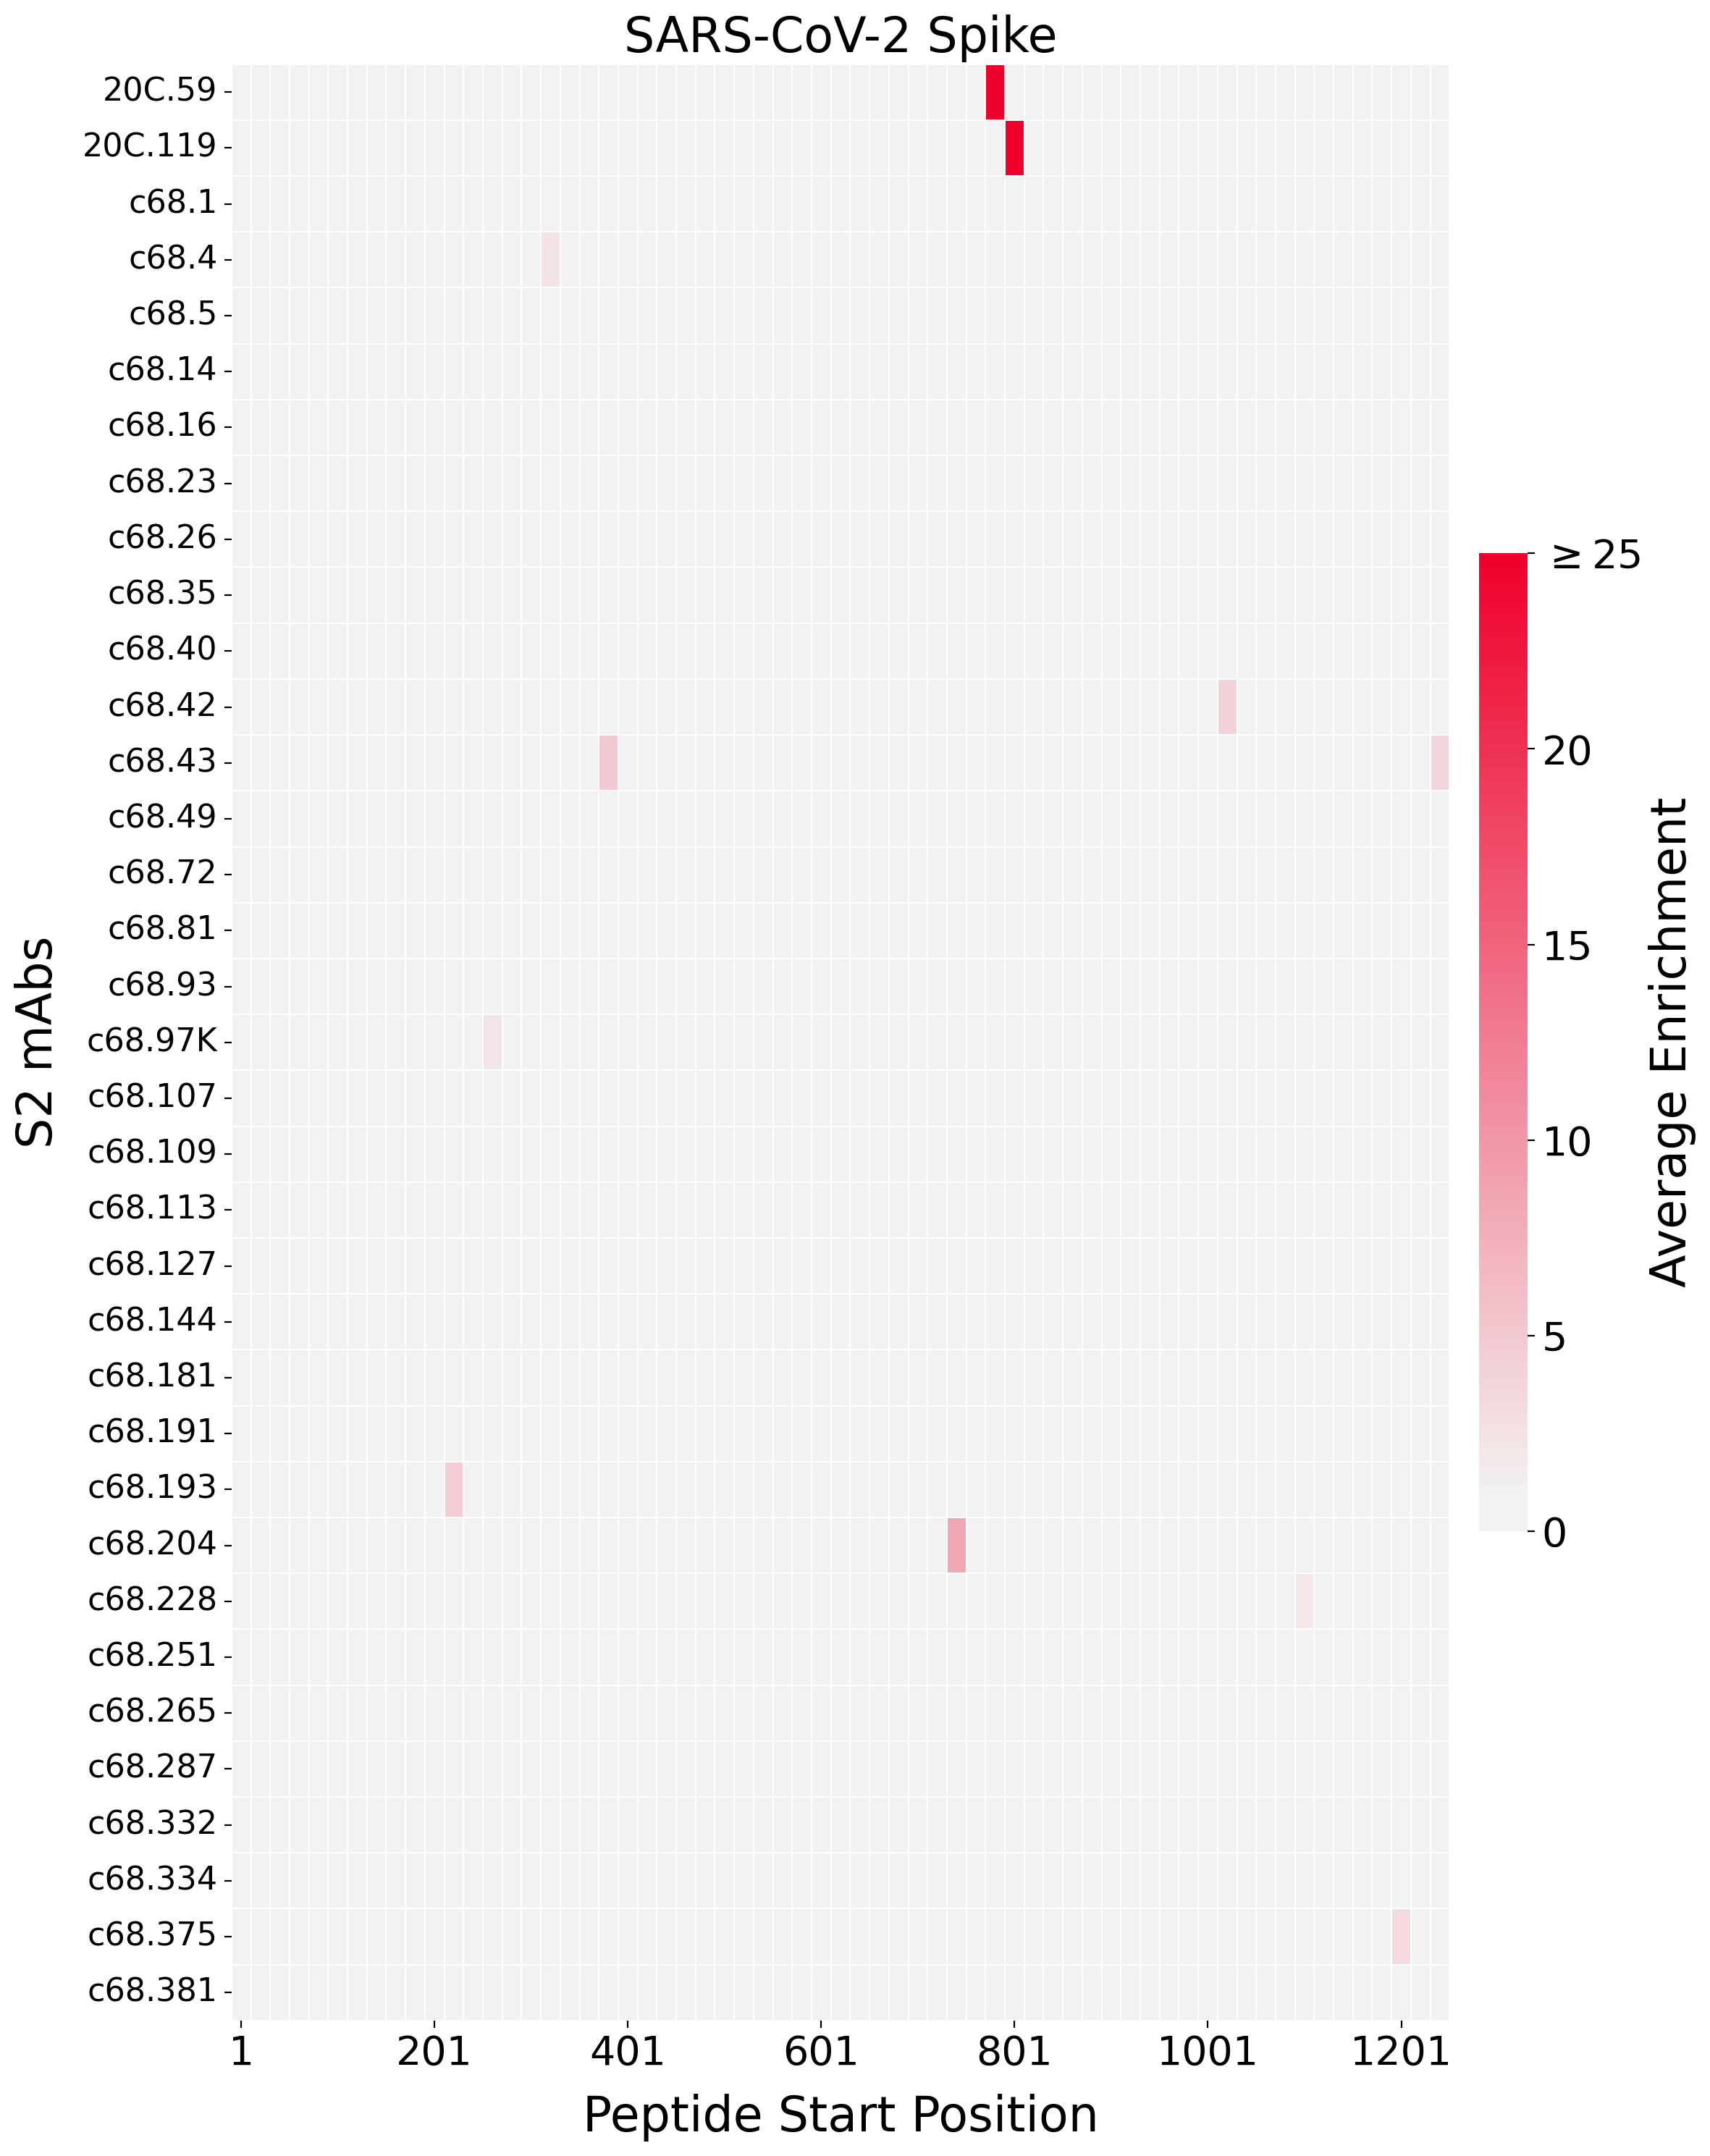

In [3]:
vmin=0
vmax=25
cmap_yticklabels = [0, 5, 10, 15, 20]
cmap_yticklabels.append(f'$\geq{vmax}$')
cmap_label = 'Average Enrichment'

yticklabels = {
    'S2' : [
    "20C.59","20C.119",
    "c68.1",  "c68.4",  "c68.5",  "c68.14", "c68.16", "c68.23", "c68.26", "c68.35", "c68.40", "c68.42",
    "c68.43", "c68.49", "c68.72", "c68.81", "c68.93", "c68.97K","c68.107","c68.109","c68.113","c68.127",
    "c68.144","c68.181","c68.191","c68.193","c68.204","c68.228","c68.251","c68.265","c68.287","c68.332",
    "c68.334","c68.375","c68.381"],
    
    'NTD' : [
    "c68.2",  "c68.8",  "c68.24", "c68.32", "c68.51", "c68.66", "c68.80", "c68.101","c68.137","c68.157",
    "c68.164","c68.171","c68.196","c68.202","c68.213","c68.227","c68.276","c68.326","c68.363"]
}

enr_col = 'avg_cutoff_enr'
target = 'S2'

plot_df = cutoff_enr_df[cutoff_enr_df['mAb_target']==target][['sample_ID','Prot_Start',enr_col]]
plot_df = plot_df.pivot(index='sample_ID', columns='Prot_Start', values=enr_col)

plot_df = plot_df.reindex(yticklabels[target]) 

fig, ax = plt.subplots(figsize=[12,15])
cmap = sns.diverging_palette(240, 10, s=100, l=50, sep=10, as_cmap=True)
sns_ax = sns.heatmap(plot_df, cmap=cmap, center=0, square=False, linewidths=0.1, vmin=vmin, vmax=vmax,
                     cbar_kws={"shrink": .5, "label": cmap_label, "pad": 0.02})
ax.set_title(f'SARS-CoV-2 Spike', fontsize=24)
ax.tick_params(axis="x", labelsize=20, rotation=0)
ax.set_xlabel('Peptide Start Position', fontsize=24, verticalalignment='top', labelpad=10)
ax.xaxis.set_major_locator(plt.FixedLocator([0.5,10.5,20.5,30.5,40.5,50.5,60.5]))
ax.tick_params(axis="y", labelsize=16)
ax.set_ylabel(f'{target} mAbs', fontsize=24, labelpad=10)
sns_ax.figure.axes[-1].yaxis.label.set_size(24)
sns_ax.collections[0].colorbar.ax.tick_params(labelsize=20)
sns_ax.collections[0].colorbar.ax.set_yticklabels(cmap_yticklabels)
plt.tight_layout()
plt.savefig(f"SARSCoV2_{target}_{enr_col}_{metric}_fpr{fpr}.pdf")
plt.show()